In [7]:
! pip install verde harmonica pandas matplotlib

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import pandas as pd
import warnings

In [9]:
warnings.filterwarnings('ignore')

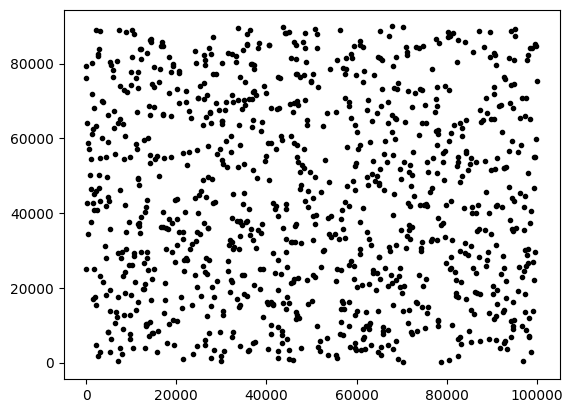

In [10]:
region = [0, 100e3, 0, 90e3]
coordinates = vd.scatter_points(region, size=1000, extra_coords=1000)

plt.plot(coordinates[0], coordinates[1], ".k")

In [11]:
len(coordinates[0])

1000

In [12]:
prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
gz = hm.prism_gravity(coordinates, prismas, densidades, field="g_z")

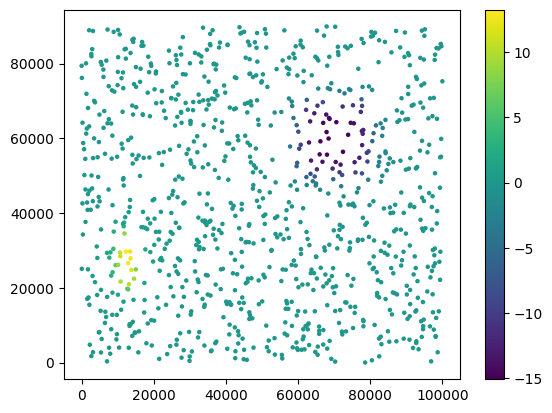

In [13]:
plt.scatter(coordinates[0], coordinates[1], s=5, c=gz)
plt.colorbar()

In [14]:
# Fontes equivalentes
fontes = hm.EquivalentSourcesGB(damping=1,depth=1e3)
altura = np.zeros(1000)
fontes.fit([coordinates[0],coordinates[1],altura],data=gz) # o que faz essa funcao .fit?

EquivalentSourcesGB(damping=1, depth=1000.0)

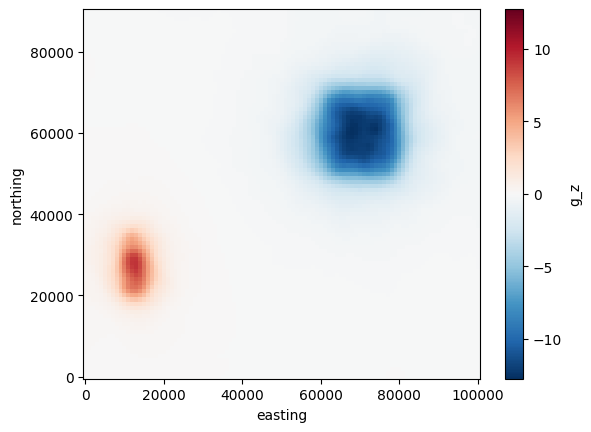

In [15]:
grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=1000)
gz_grid_eq = fontes.grid(grid_coords_eq,data_names="g_z")
gz_grid_eq.g_z.plot()

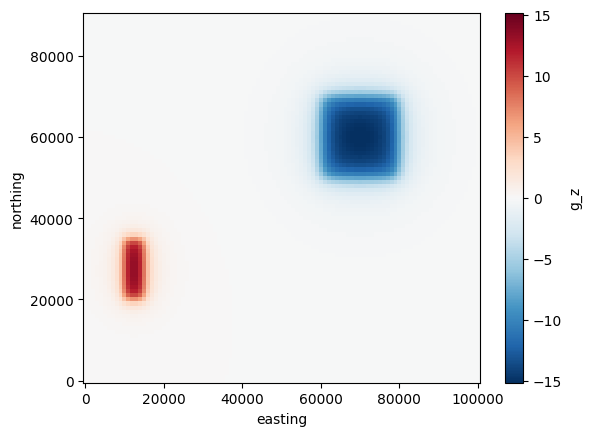

In [16]:
# Malha regular
grid_coords = vd.grid_coordinates(region, spacing=1e3, extra_coords=1000)
gz_grid = hm.prism_gravity(grid_coords, prismas, densidades, field="g_z")
grid_true = vd.make_xarray_grid(grid_coords, gz_grid, data_names="g_z", extra_coords_names="upward")
grid_true.g_z.plot()


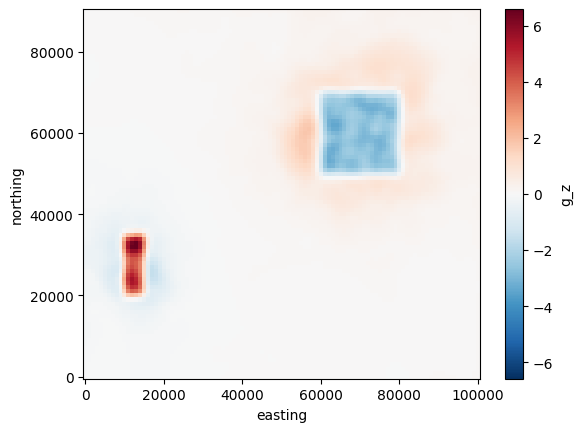

In [60]:
##################################### Diferença
residuo = grid_true - gz_grid_eq
residuo.g_z.plot()

In [76]:
residuo.g_z

<xarray.DataArray 'g_z' (northing: 91, easting: 101)> Size: 74kB
array([[-0.05753988, -0.04970978, -0.04145323, ...,  0.04973152,
         0.06033342,  0.07123762],
       [-0.05800293, -0.04737197, -0.03545344, ...,  0.04114086,
         0.05147536,  0.06409709],
       [-0.0597265 , -0.04694842, -0.03220024, ...,  0.03521567,
         0.04346114,  0.05770586],
       ...,
       [ 0.03294946,  0.02481878,  0.01744546, ...,  0.17876257,
         0.19885025,  0.21827509],
       [ 0.03591943,  0.02682956,  0.01831239, ...,  0.19730044,
         0.21877031,  0.23678435],
       [ 0.04167128,  0.03453184,  0.02842841, ...,  0.21791892,
         0.23673304,  0.25212484]])
Coordinates:
  * easting   (easting) float64 808B 0.0 1e+03 2e+03 ... 9.8e+04 9.9e+04 1e+05
  * northing  (northing) float64 728B 0.0 1e+03 2e+03 ... 8.8e+04 8.9e+04 9e+04
    upward    (northing, easting) float64 74kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03

In [77]:
gz_grid_eq.g_z

<xarray.DataArray 'g_z' (northing: 91, easting: 101)> Size: 74kB
array([[ 0.06897677,  0.06175927,  0.05410675, ..., -0.05883534,
        -0.06926502, -0.07999611],
       [ 0.07086528,  0.06097008,  0.04978228, ..., -0.05065452,
        -0.06080343, -0.07323884],
       [ 0.07420664,  0.06231445,  0.04845283, ..., -0.04516226,
        -0.05320761, -0.06725166],
       ...,
       [-0.037782  , -0.02988419, -0.02275732, ..., -0.22651462,
        -0.24392831, -0.26083731],
       [-0.04073099, -0.03186895, -0.02359261, ..., -0.24237628,
        -0.26141394, -0.2771314 ],
       [-0.04645632, -0.03953954, -0.03367124, ..., -0.26047686,
        -0.27707802, -0.29037305]])
Coordinates:
  * easting   (easting) float64 808B 0.0 1e+03 2e+03 ... 9.8e+04 9.9e+04 1e+05
  * northing  (northing) float64 728B 0.0 1e+03 2e+03 ... 8.8e+04 8.9e+04 9e+04
    upward    (northing, easting) float64 74kB 1e+03 1e+03 1e+03 ... 1e+03 1e+03
Attributes:
    metadata:  Generated by EquivalentSourcesGB(damping=1, depth=1000.0)

In [95]:
################################# R_2 verdadeiro
media_grid_eq = sum(sum(gz_grid_eq.g_z))/grid_true.g_z.size

somatoria_residuo = sum(sum(residuo.g_z))**2 

diferenca = [(d - media_grid_eq)**2 for d in gz_grid_eq.g_z]
soma = 0
for g in gz_grid_eq.g_z:
    soma = soma + (g - media_grid_eq)**2

R_2 = 1 - somatoria_residuo/sum(soma)
R_2

<xarray.DataArray 'g_z' ()> Size: 8B
array(-0.93392772)
Coordinates:
    upward    float64 8B 1e+03
    northing  float64 8B 9e+04
    easting   float64 8B 1e+05

In [94]:
################################# R_2 verdadeiro

R_2 = sum(sum([res**2 for res in residuo.g_z]))/residuo.g_z.size
#grid_true_medio = sum([d for d in grid_true.g_z])/grid_true.g_z[0].size

<xarray.DataArray 'g_z' ()> Size: 8B
array(0.51889685)
Coordinates:
    upward    float64 8B 1e+03
    northing  float64 8B 9e+04
    easting   float64 8B 1e+05

In [18]:
# Using cross-validation to evaluate how well 
# these equivalent sources can accurately predict the values of the field
score_first_guess = np.mean(
    vd.cross_val_score(
        fontes,
        coordinates,
        gz,
    )
)
R_2 = score_first_guess
R_2

0.9556431922601838

In [24]:
##################################### Colocando blocos nas fontes equivalentes
R_2 = []
sources = []

block = [block for block in range(50,102050,2000)]
for block_size in block:
    fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=block_size, depth_type="constant")
    # These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

    fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
    # During this step the point sources are created through the block averaging process.

    # Using cross-validation to evaluate how well 
    # these equivalent sources can accurately predict the values of the field
    score = np.mean(
        vd.cross_val_score(
            fontes_block,
            coordinates,
            gz,
        )
    )
    R_2.append(score)
    sources.append(fontes_block.points_[0].size)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Erro')

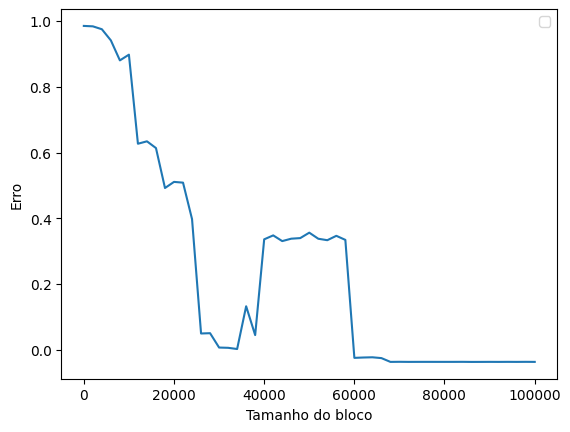

In [25]:
plt.plot(block,R_2)
plt.legend()
plt.xlabel('Tamanho do bloco')
plt.ylabel('Erro')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Numero de fontes')

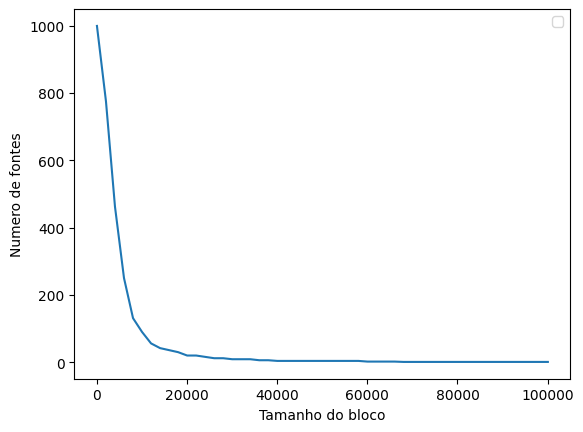

In [26]:
plt.plot(block,sources)
plt.legend()
plt.xlabel('Tamanho do bloco')
plt.ylabel('Numero de fontes')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Erro')

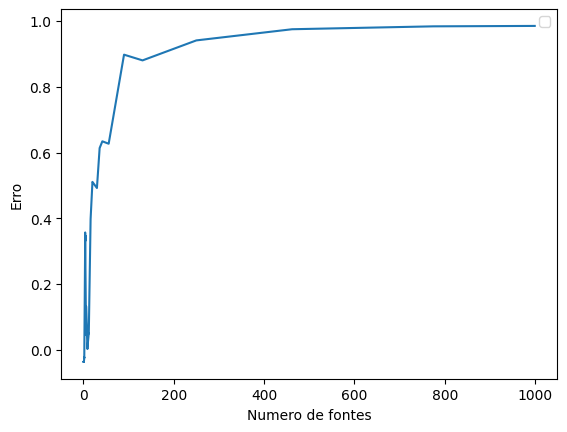

In [27]:
plt.plot(sources,R_2)
plt.legend()
plt.xlabel('Numero de fontes')
plt.ylabel('Erro')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Erro')

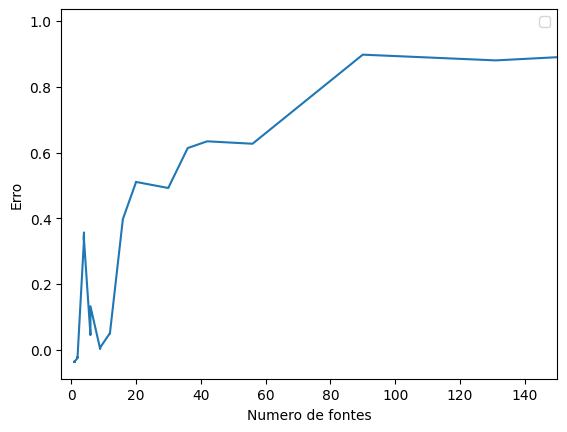

In [28]:
plt.plot(sources,R_2)
plt.legend()
plt.xlabel('Numero de fontes')
plt.xlim(-3,150)
plt.ylabel('Erro')